# Ballot Polling without Replacement

## A martingale test for the mean for sampling with replacement

We observe $X_1, X_2, \ldots$ IID $F$. Suppose $\mathbb{E} X_j = t$.
Define

$$
   Y_n \equiv \int_0^1 \prod_{j=1}^n \left ( \gamma \left [ X_j/t -1 \right ] + 1 \right ) d\gamma.
$$

This is a polynomial in $\gamma$ of degree at most $n$, with constant term $1$.
Each $X_j$ appears linearly.
Under the null hypothesis that the expected value of $F$ is $t$, $\mathbb{E} X_1 = t$,
and 

$$
  \mathbb{E} \left ( X_j \mid X_1, \ldots, X_{j-1} \right ) = t.
$$

Now 

$$
   Y_1 = \int_0^1 \left ( \gamma [ X_1/t - 1] + 1 \right ) d\gamma = 
   \left [ (\gamma^2/2) [X_1/t - 1] + \gamma \right ]_{\gamma=0}^1 = [X_1/t - 1]/2 + 1 = \frac{X_1}{2t} + 1/2.
$$

Thus, under the null, 
$$
   \mathbb{E} Y_1 = \frac{\mathbb{E}X_1}{2t} + 1/2 = \frac{t}{2t} + 1/2 = 1.
$$

Also,

$$
   \mathbb{E}(Y_n | X_1, \ldots, X_{n-1}) =
   \mathbb{E} \left . \left [ \int_0^1 \prod_{j=1}^n \left (\gamma [ X_j/t -1 ] + 1 \right ) d\gamma \right | X_1, \ldots, X_{n-1} \right ]
$$
$$
  = \int_0^1  \left (\gamma \left [ \mathbb{E}(X_n | X_1, \ldots, X_{n-1})/t 
  - 1 \right ] + 1 \right ) \prod_{j=1}^{n-1} \left ( \gamma \left [ X_j/t - 1 \right ] + 1 \right ) d\gamma 
$$
$$
  = \int_0^1  \left (\gamma \left [ t/t - 1 \right ] + 1 \right ) \prod_{j=1}^{n-1} \left ( \gamma \left [ X_j/t - 1 \right ] + 1 \right ) d\gamma 
$$
$$
  = \int_0^1  \prod_{j=1}^{n-1} \left ( \gamma \left [ X_j/t -1 \right ] + 1 \right ) d\gamma = Y_{n-1}.
$$

Thus, under the null hypothesis, $(Y_j )_{j=1}^N$ is a nonnegative martingale with expected value 1, and Kolmogorov's inequality implies that for any $i \in \{1, 2, \ldots, \}$,

$$
   \Pr \left ( \max_{1 \le j \le i} Y_j(t) > 1/p \right ) \le p.
$$

Set 

$$
    c_j \equiv X_j/t -1,
$$

and re-write the polynomial

$$
 \prod_{j=1}^n \left (\gamma [ X_j/t -1 ] + 1 \right ) = \prod_{j: c_j \ne 0} c_j(\gamma + c_j^{-1}).
$$

$$
   Y_j = \int_0^1 \prod_{j: c_j \ne 0} c_j(\gamma + c_j^{-1}) d\gamma =
   \left ( \prod_{j: c_j \ne 0} c_j \right ) \int_0^1 \prod_{j: c_j \ne 0} (\gamma + c_j^{-1}) d\gamma.
$$

In [1]:
# This is the first cell with code: set up the Python environment
%matplotlib inline
import matplotlib.pyplot as plt
import math

import numpy as np
from numpy.polynomial import polynomial as P

import scipy as sp
import scipy.stats
from scipy.stats import binom
from scipy.optimize import brentq

import random

import pandas as pd

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML

random.seed(123456789)

In [2]:
## Recursive integral from 0 to 1 of a polynomial in terms of its roots

def integral_from_roots(c, maximal = True):
    '''
    Integrate the polynomial \prod_{k=1}^n (x-c_j) from 0 to 1, i.e.,
       \int_0^1 \prod_{k=1}^n (x-c_j) dx
    using a recursive algorithm.
    
    If maximal == True, finds the maximum of the integrals over lower degrees:
       \max_{1 \le k \le n} \int_0^1 \prod_{j=1}^k (x-c_j) dx
    
    Input
    ------
    c : array of roots
    
    Returns
    ------
    the integral or maximum integral
    '''
    n = len(c)
    a = np.zeros((n+1,n+1))
    a[0,0]=1
    for k in np.arange(n):
        for j in np.arange(n+1):
            a[k+1,j] = -c[k]*((k+1-j)/(k+1))*a[k,j]
            a[k+1,j] += 0 if j==0 else (1-c[k])*(j/(k+1))*a[k,j-1]
    if maximal:
        integrals = np.zeros(n+1)
        for k in np.arange(1,n+1):
            integrals[k] = np.sum(a[k,:])/(k+1)
        integral = np.max(integrals[1:])
    else:
        integral = np.sum(a[n,:])/(n+1)
    return integral   

In [3]:
def HK_ps_se_p(x, N, t, random_order = True):
    '''
    Harold Kaplan p-value for the hypothesis that the mean of a nonnegative 
    population with N elements is t, computed using recursive algorithm devised
    by Steve Evans.
    
    The alternative is that the mean is larger than t.
    If the random sample x is in the order in which the sample was drawn, it is
    legitimate to set random_order = True. 
    If not, set random_order = False. 
    
    If N = np.inf, treats the sampling as if it is with replacement.
    If N is finite, assumes the sample is drawn without replacement.
    
    Input:   x, array-like, the sample
    ------   N, int, population size. Use np.inf for sampling with replacement
             t, double, the hypothesized population mean
             random_order, boolean, is the sample in random order?
            
    Returns: p, double, p-value of the null
    -------  mart_vec, array, martingale as elements are added to the sample
      
    
    '''
    x = np.array(x)
    assert all(x >=0),  'Negative value in a nonnegative population!'
    assert len(x) <= N, 'Sample size is larger than the population!'
    assert N > 0,       'Population size not positive!'
    if np.isfinite(N):
        assert N == int(N), 'Non-integer population size!'
    Stilde = (np.insert(np.cumsum(x),0,0)/N)[0:len(x)] # \tilde{S}_{j-1}
    t_minus_Stilde = t - Stilde
    mart_max = 1
    mart_vec = np.ones_like(x, dtype=np.float)
    if any(t_minus_Stilde < 0): # sample total exceeds hypothesized population total
        mart_max = np.inf
    else: 
        jtilde = 1 - np.array(list(range(len(x))))/N
        c = np.multiply(x, np.divide(jtilde, t_minus_Stilde))-1  # need to test for zeros!
        for j in range(len(x)):
            r = -np.array([1/cc for cc in c[0:j+1] if cc != 0]) # roots
            if r.size > 0:
                Y_norm = np.prod(np.array([cc for cc in c[0:j+1] if cc != 0])) # multiplicative constant
                mart = Y_norm*integral_from_roots(r, maximal = False)
                mart_max = max(mart_max, mart) if random_order else mart
            else:
                mart_max = max(mart_max, 1) if random_order else 1
            mart_vec[j] = mart_max
    p = min(1/mart_max,1)
    return p, mart_vec

In [4]:
x = np.array([0]*30 + [1]*50)
random.shuffle(x)
p, m_v = HK_ps_se_p(x, np.inf, 0.5)

In [5]:
p, m_v

(0.09523809523809523,
 array([ 1.5       ,  2.33333333,  3.75      ,  6.2       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5       , 10.5       , 10.5       , 10.5       ,
        10.5       , 10.5    

In [6]:
def plotBinomialSPRT(n, p, p0, p1, alpha, log_only=True):
    '''
       Plots the progress of the SPRT for n iid Bernoulli trials with probabiity p
       of success, for testing the hypothesis that p=p0 against the hypothesis p=p1
       with significance level alpha.
       Compares with the Kaplan martingale approach that doesn't use the alternative 
       hypothesis.
       
       If log_only, plots only the log; otherwise also plots raw
    '''
    if log_only:
        fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    else:
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
    trials = sp.stats.binom.rvs(1, p, size=n+1)  # leave room to start at 1
    terms = np.ones(n+1)
    sfac = p1/p0
    ffac = (1.0-p1)/(1.0-p0)
    terms[trials == 1.0] = sfac
    terms[trials == 0.0] = ffac
    terms[0] = 1.0
    logterms = np.log(terms)
    #
    p_mart, mart_vec = HK_ps_se_p(trials, np.inf, p0)
    log_mart_vec = np.log(mart_vec)
    
    if not log_only:
        ax[0].plot(range(n+1),np.cumprod(terms), color='b', label=r'SPRT')
        ax[0].plot(range(n+1), mart_vec, color='y', label=r'Kaplan')
        ax[0].axhline(y=1/alpha, xmin=0, xmax=n, color='g', label=r'$1/\alpha$')
        ax[0].set_title('Wald SPRT & Kaplan Martingale: p=' 
                    + p + ', p0=' + p0 + ', p1=' + p1)
        ax[0].set_ylabel('1/p')
        ax[0].legend(loc='best')
        ax[1].plot(range(n+1),np.cumsum(logterms), color='b', linestyle='-', label=r'SPRT')
        ax[1].plot(range(n+1), log_mart_vec, color='y', linestyle='-', label=r'Kaplan')
        ax[1].axhline(y=math.log(1/alpha), xmin=0, xmax=n, color='g', linestyle="--",
                   label=r'$log(1/\alpha)$')
        ax[1].set_ylabel('log(1/p)')
        ax[1].set_xlabel('trials')
        ax[1].legend(loc='best')
    else:
        ax.set_title('Wald SPRT & Kaplan Martingale: p=' 
                    + str(p) + ', p0=' + str(p0) + ', p1=' + str(p1))
        ax.plot(range(n+1),np.cumsum(logterms), color='b', linestyle='-', label=r'SPRT')
        ax.plot(range(n+1), log_mart_vec, color='y', linestyle='-', label=r'Kaplan')
        ax.axhline(y=math.log(1/alpha), xmin=0, xmax=n, color='g', linestyle="--",
                   label=r'$log(1/\alpha)$')
        ax.set_ylabel('log(1/p)')
        ax.set_xlabel('trials')
        ax.legend(loc='best')
    plt.show()

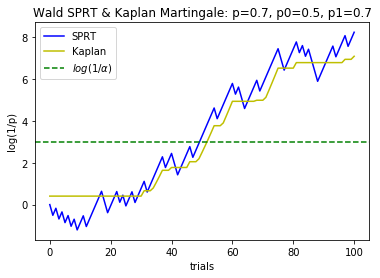

In [7]:
plotBinomialSPRT(100, .7, .5, .7, .05)

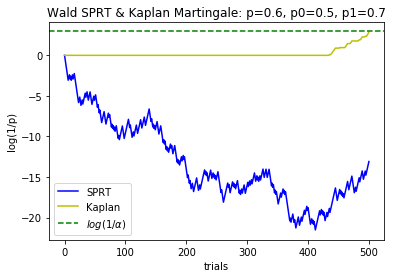

In [8]:
plotBinomialSPRT(500, .6, .5, .7, .05)

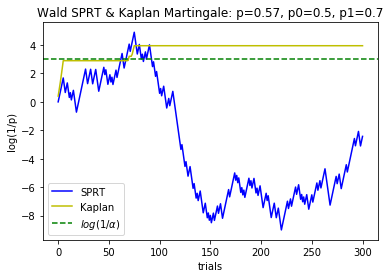

In [9]:
plotBinomialSPRT(300, .57, .5, .7, .05)

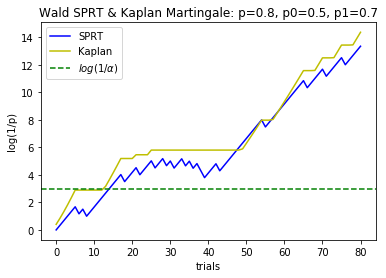

In [10]:
plotBinomialSPRT(80, .8, .5, .7, .05)

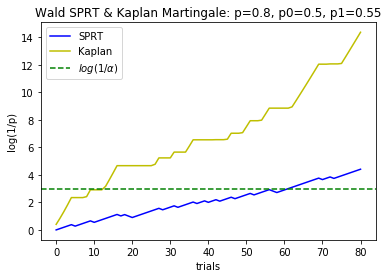

In [11]:
plotBinomialSPRT(80, .8, .5, .55, .05)

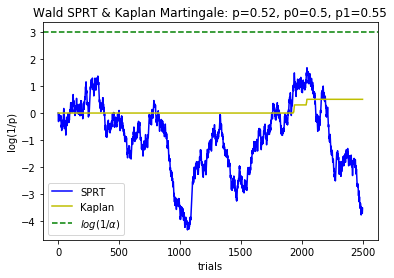

In [15]:
plotBinomialSPRT(5000, .52, .5, .55, .05)

## Power simulations

In [ ]:
reps = 1000
for p_0 in [0.51, 0.52, 0.55, 0.6, 0.65, 0.7]:
    for r in reps:
        trials = sp.stats.binom.rvs(0, p_0, size=n)  # leave room to start at 1
        p_mart, mart_vec = HK_ps_se_p(trials, np.inf, p0)